In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score

In [3]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils
import GeoCompute as gC

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()
numCores = multiprocessing.cpu_count()

lonMin = (float)(config['TP_SEC_ORDER']['LON_MIN'])
lonMax = (float)(config['TP_SEC_ORDER']['LON_MAX'])

latMin = (float)(config['TP_SEC_ORDER']['LAT_MIN'])
latMax = (float)(config['TP_SEC_ORDER']['LAT_MAX'])

print(lonMin,latMin)
print(lonMax,latMax)

increStep = (float)(config['TP_SEC_ORDER']['INCR_STEP'])
incrRes = (int)(config['TP_SEC_ORDER']['INCR_RES'])

fileDir = config['TP_SEC_ORDER']['SOURCE_DIR']
dirToStore = config['TP_SEC_ORDER']['DEST_DIR']

print("SOURCE_DIR = %s"%fileDir)
print("DEST_DIR = %s"%dirToStore)

-120.5 33.9
-119.0 34.44
SOURCE_DIR = ../Data/M120_50_M119_00_33_90_34_44/Container/
DEST_DIR = ../Data/M120_50_M119_00_33_90_34_44/Container/SparseTP/


In [4]:
heatMapGrid = hMUtil.generate_grid(lonMin, lonMax, latMin, latMax, increStep, incrRes)
boundaryArray = heatMapGrid[2]
horizontalAxis = heatMapGrid[0]
verticalAxis = heatMapGrid[1]
totalStates = horizontalAxis.shape[0] * verticalAxis.shape[0]

In [5]:
def get_index_from_lon_lat(lon,lat):
    retVal = -1
    for boundary in boundaryArray: 
        if(lon >= boundary[0]) and (lon < boundary[1]) \
            and (lat >= boundary[2]) and (lat < boundary[3]):
            retVal = boundary[4]
            break 
    return retVal

In [6]:
opFile = dirToStore + 'TPM.npz'
# opFile = dirToStore + 'TPM_.npz'
tpMatrix = scipy.sparse.load_npz(opFile)

In [22]:
def get_vessel_init_status(lonStart,latStart):
    vesselState = np.zeros((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    for boundary in boundaryArray :
        if((lonStart >= boundary[0]) \
            and (lonStart < boundary[1]) \
           
            and (latStart >= boundary[2]) \
            and (latStart < boundary[3]) \
          ):
            vesselState[boundary[4]] = 1.0
            break
    return vesselState

def get_grid_object(lonStart,latStart):
    ret = -1
    for boundary in boundaryArray :
        if((lonStart >= boundary[0]) \
            and (lonStart < boundary[1]) \
           
            and (latStart >= boundary[2]) \
            and (latStart < boundary[3]) \
          ):
            ret = boundary[4]
            break
    return ret

def get_next_greedy_block(prev,curr):
    tPRow = prev*totalStates + curr
    nextGreedyProb = tpMatrix[tPRow,:].copy()
    print(np.sum(nextGreedyProb))
    print(np.argmax(nextGreedyProb))
    return np.argmax(nextGreedyProb)

        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  209251000  2017-01-01T14:59:56  34.28535 -120.34157  19.6  104.0    104.0   
1  209251000  2017-01-01T15:29:21  34.24127 -120.15367  20.0  105.0    106.0   
2  209251000  2017-01-01T15:58:56  34.19597 -119.96092  20.2  105.0    106.0   
3  209251000  2017-01-01T16:29:33  34.15192 -119.76097  20.3  103.0    104.0   
4  209251000  2017-01-01T16:59:08  34.10740 -119.56688  20.4  106.0    107.0   
5  209251000  2017-01-01T17:29:50  34.06138 -119.36828  19.8  105.0    106.0   
6  209251000  2017-01-01T17:59:38  34.00643 -119.19950  16.4  119.0    121.0   
7  209251000  2017-01-01T18:29:49  33.94850 -119.08112  11.8  119.0    121.0   
8  209251000  2017-01-01T18:53:00  33.91053 -119.00117  11.9  119.0    120.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  CSCL PUSAN  IMO9307229    C4NK2      1004.0  under way using engine   
1  CSCL PUSAN  IMO9307229    C4NK2      1004.0  und

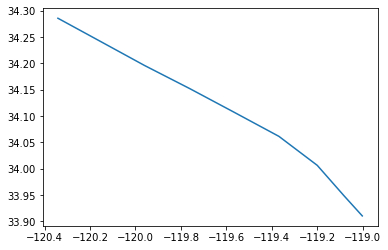

In [36]:
# oneVessel = "../Data/M120_50_M119_00_33_90_34_44/MMSIContainer/100.csv"
oneVessel = "../Data/M120_50_M119_00_33_90_34_44/MMSIContainer/0.csv"
oneVesselLastDataOne,_ = aISDM.load_data_from_csv(oneVessel)
oneVesselLastDataOneLon = oneVesselLastDataOne["LON"]
oneVesselLastDataOneLat = oneVesselLastDataOne["LAT"]
plt.plot(oneVesselLastDataOneLon,oneVesselLastDataOneLat)
print(oneVesselLastDataOne)

In [38]:
prevState = get_grid_object(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
print(prevState)
currState = get_grid_object(oneVesselLastDataOneLon.iloc[1],oneVesselLastDataOneLat.iloc[1])
print(currState)
pred1 = get_next_greedy_block(prevState,currState)
pred2 = get_next_greedy_block(currState,pred1)
pred3 = get_next_greedy_block(pred1,pred2)
pred4 = get_next_greedy_block(pred2,pred3)
pred5 = get_next_greedy_block(pred3,pred4)
pred6 = get_next_greedy_block(pred4,pred5)
pred7 = get_next_greedy_block(pred5,pred6)
pred8 = get_next_greedy_block(pred6,pred7)
# pred9 = get_next_greedy_block(pred7,pred8)


5715
5134
1.0
4553
1.0
3822
1.0
3241
1.0
2659
1.0000000000000002
1926
0.9999999999999999
890
1.0
299
1.0
299


In [39]:
# predList = [pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9]
predList = [pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8]

In [40]:
def compute_heat_map(loc):
    npHeatMap = np.ones((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    npHeatMap[loc] = 0
    return npHeatMap

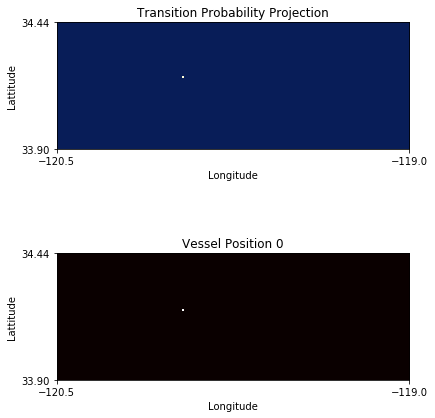

In [43]:
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.49, 0.30])
ax2 = fig.add_axes([0.1, 0.55, 0.49, 0.30])

if useAspect == 1:
    figHeight = figWidth/aspectRatio

def animate(i):
    vesselCurrPos = get_vessel_init_status(oneVesselLastDataOneLon.iloc[i+2],oneVesselLastDataOneLat.iloc[i+2])
    vesselCurrPos = np.reshape(vesselCurrPos,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    
    vesselCurrPos = np.flip(vesselCurrPos,axis=0)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    titleStr = 'Vessel Position %d'%((i))
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Lattitude')
    ax2.set_title('Transition Probability Projection')
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([latMin,latMax])

    ax1.imshow(vesselCurrPos,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
    #sequence of vessel states
    vesselProbState = compute_heat_map(predList[i])
    vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    vesselProbState = np.flip(vesselProbState,axis=0)
    iMShowHandler = ax2.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.1)
    
# anim = animation.FuncAnimation(fig, animate,frames=9, interval=1000)
anim = animation.FuncAnimation(fig, animate,frames=7, interval=1000)

In [44]:
HTML(anim.to_html5_video())

In [45]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

In [46]:
anim.save('GreedySeqOneSecOrder.mp4', writer=writer)